In [1]:
#Imports

import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from skimage import io

import random
import tensorflow as tf
from PIL import Image 
import warnings
warnings.simplefilter(action='ignore')
import tensorflow_addons as tfa
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ReLU, MaxPooling2D, Conv2D, Dropout, Activation, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16

## Loading and pre-processing the data

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path(r'C:\Users\omax1\Desktop\USC\DSCI 552\data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [4]:
def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        
        img = Image.open(img_loc_str).convert('RGB')
        
        # Convert PIL to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])
        
        # Normalize the image to the [0, 1] range
        
        img =  tf.cast(img, tf.float32) / 255.0
        
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    #Set Tensor shape
    X.set_shape([299, 299, 3])
    y.set_shape([])
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

## Data Augmentation for CNN

In [5]:
def augment(image, label):
    #Rotate
    image = tf.image.rot90(image)
    #Flip
    image = tf.image.flip_left_right(image)
    #Contrast
    image = tf.image.random_contrast(image, lower=0.2, upper=1)
    #Hue
    image = tf.image.adjust_hue(image, 0.3)
    
    return image, label

tf_dataset_train_augmented = tf_dataset_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

## Training Three-Layer CNN / MLP

In [6]:
CNN = Sequential([
    # First Layer
    Conv2D(8, (3, 3), padding='same', input_shape=(299, 299, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(), ReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Second Layer
    Conv2D(16, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(), ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Layer
    Conv2D(32, (4, 4), padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(), ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(2, activation='softmax')])

CNN.compile(optimizer ='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

h = CNN.fit(
    tf_dataset_train_augmented,
    epochs = 20,
    validation_data = tf_dataset_val,
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
                 ModelCheckpoint('bestCNN.h5', monitor='val_accuracy', save_best_only=True)])
 

00:06:18 | WARNING | module_wrapper  | From C:\Users\omax1\anaconda3\Lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



00:06:18 | WARNING | module_wrapper  | From C:\Users\omax1\anaconda3\Lib\site-packages\keras\src\layers\pooling\max_pooling2d.py:161: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



00:06:18 | WARNING | module_wrapper  | From C:\Users\omax1\anaconda3\Lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Epoch 1/20



00:06:19 | WARNING | module_wrapper  | From C:\Users\omax1\anaconda3\Lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.



00:06:19 | WARNING | module_wrapper  | From C:\Users\omax1\anaconda3\Lib\site-packages\keras\src\engine\base_layer_utils.py:384: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.



928/928 [==============================] - 208s 222ms/step - loss: 1.0735 - accuracy: 0.6405 - val_loss: 3.0847 - val_accuracy: 0.3218
Epoch 2/20
928/928 [==============================] - 206s 221ms/step - loss: 0.6799 - accuracy: 0.6752 - val_loss: 0.6303 - val_accuracy: 0.8104
Epoch 3/20
928/928 [==============================] - 205s 221ms/step - loss: 0.6181 - accuracy: 0.7139 - val_loss: 5.8502 - val_accuracy: 0.3264
Epoch 4/20
928/928 [==============================] - 206s 221ms/step - loss: 0.5969 - accuracy: 0.7224 - val_loss: 5.8347 - val_accuracy: 0.3248
Epoch 5/20
928/928 [==============================] - 205s 221ms/step - loss: 0.5886 - accuracy: 0.7279 - val_loss: 1.1790 - val_accuracy: 0.5929
Epoch 6/20
928/928 [==============================] - 205s 221ms/step - loss: 0.5633 - accuracy: 0.7451 - val_loss: 1.5290 - val_accuracy: 0.5971
Epoch 7/20
928/928 [==============================] - 205s 221ms/step - loss: 0.5535 - accuracy: 0.7517 - val_loss: 25.0332 - val_accur

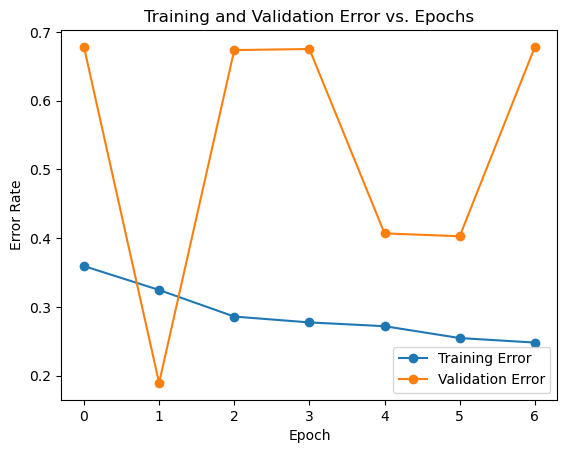

401/401 [==============================] - 29s 73ms/step
              precision    recall  f1-score   support

           0       0.35      0.61      0.45      4418
           1       0.67      0.41      0.51      8405

    accuracy                           0.48     12823
   macro avg       0.51      0.51      0.48     12823
weighted avg       0.56      0.48      0.49     12823



In [7]:
#Plot the training and validation errors vs. epochs
trainError = [1 - score for score in h.history['accuracy']]
validationError = [1 - score for score in h.history['val_accuracy']]

plt.plot(trainError, label='Training Error', marker='o')  # Plotting error
plt.plot(validationError, label='Validation Error', marker='o')  # Plotting error
plt.title('Training and Validation Error vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

#Report Precision, Recall, and F1 score for your model
trueLabels = []
bestCNNpred = load_model('bestCNN.h5').predict(tf_dataset_test)
predLabels = np.argmax(bestCNNpred, axis=1).flatten()

for image, label in tf_dataset_test.unbatch():
    trueLabels.append(label.numpy())
    
trueLabels = np.array(trueLabels).flatten()
print(classification_report(trueLabels, predLabels))


## Data Augmentation for Pre-Trained Models

In [8]:
#Resize Image for pre-trained models
def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        
        img = Image.open(img_loc_str).convert('RGB')
        
        # Convert PIL to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [224, 224])
        
        # Normalize the image to the [0, 1] range
        
        img =  tf.cast(img, tf.float32) / 255.0
        
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    #Set Tensor shape
    X.set_shape([224, 224, 3])
    y.set_shape([])
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 


#Augment
tf_dataset_train_augmented = tf_dataset_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

## Transfer Learning using EfficientNetB0

In [9]:
#EfficientNetB0
ENB0base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
ENB0base.trainable = False

ENB0model = Sequential([
    ENB0base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')])

ENB0model.compile(optimizer ='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hENB0 = ENB0model.fit(
    tf_dataset_train_augmented,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
                 ModelCheckpoint('bestENB0.h5', monitor='val_accuracy', save_best_only=True)])


Epoch 1/20
928/928 [==============================] - 445s 475ms/step - loss: 0.7238 - accuracy: 0.5515 - val_loss: 0.7063 - val_accuracy: 0.3218
Epoch 2/20
928/928 [==============================] - 440s 474ms/step - loss: 0.6822 - accuracy: 0.5826 - val_loss: 0.7281 - val_accuracy: 0.3218
Epoch 3/20
928/928 [==============================] - 439s 472ms/step - loss: 0.6798 - accuracy: 0.5861 - val_loss: 0.7486 - val_accuracy: 0.3218
Epoch 4/20
928/928 [==============================] - 439s 473ms/step - loss: 0.6795 - accuracy: 0.5859 - val_loss: 0.7535 - val_accuracy: 0.3218
Epoch 5/20
928/928 [==============================] - 439s 473ms/step - loss: 0.6788 - accuracy: 0.5869 - val_loss: 0.7621 - val_accuracy: 0.3218
Epoch 6/20
928/928 [==============================] - 439s 473ms/step - loss: 0.6785 - accuracy: 0.5874 - val_loss: 0.7659 - val_accuracy: 0.3218


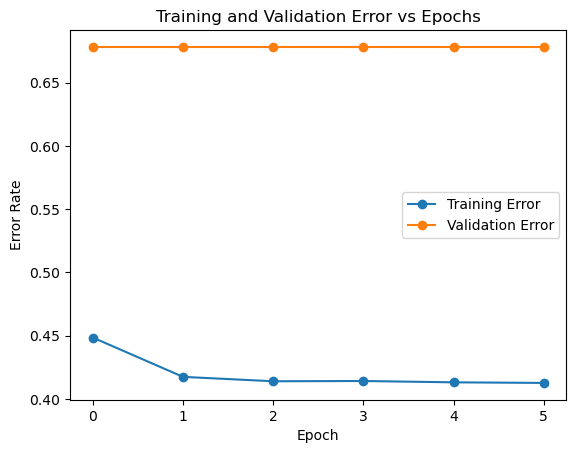

401/401 [==============================] - 134s 331ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4418
           1       0.66      1.00      0.79      8405

    accuracy                           0.66     12823
   macro avg       0.33      0.50      0.40     12823
weighted avg       0.43      0.66      0.52     12823



In [10]:
#Plot the training and validation errors vs. epochs
trainErrorENB0 = [1 - score for score in hENB0.history['accuracy']]
validationErrorENB0 = [1 - score for score in hENB0.history['val_accuracy']]

plt.plot(trainErrorENB0, label='Training Error', marker='o')  # Plotting error
plt.plot(validationErrorENB0, label='Validation Error', marker='o')  # Plotting error
plt.title('Training and Validation Error vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

#Report Precision, Recall, and F1 score for your model
bestENB0pred = load_model('bestENB0.h5').predict(tf_dataset_test)
predLabelsENB0 = np.argmax(bestENB0pred, axis=1).flatten()
print(classification_report(trueLabels, predLabelsENB0))

## Transfer Learning using ResNet50

In [11]:
#ResNet50
RN50base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
RN50base.trainable = False

RN50model = Sequential([
    RN50base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')])

RN50model.compile(optimizer ='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hRN50 = RN50model.fit(
    tf_dataset_train_augmented,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
                 ModelCheckpoint('bestRN50.h5', monitor='val_accuracy', save_best_only=True)])


Epoch 1/20
928/928 [==============================] - 973s 1s/step - loss: 0.4314 - accuracy: 0.7926 - val_loss: 1.3896 - val_accuracy: 0.5463
Epoch 2/20
928/928 [==============================] - 969s 1s/step - loss: 0.3736 - accuracy: 0.8274 - val_loss: 1.3721 - val_accuracy: 0.5350
Epoch 3/20
928/928 [==============================] - 969s 1s/step - loss: 0.3522 - accuracy: 0.8392 - val_loss: 1.2048 - val_accuracy: 0.5781
Epoch 4/20
928/928 [==============================] - 970s 1s/step - loss: 0.3324 - accuracy: 0.8523 - val_loss: 1.5271 - val_accuracy: 0.5288
Epoch 5/20
928/928 [==============================] - 970s 1s/step - loss: 0.3263 - accuracy: 0.8561 - val_loss: 1.1765 - val_accuracy: 0.5974
Epoch 6/20
928/928 [==============================] - 970s 1s/step - loss: 0.3165 - accuracy: 0.8590 - val_loss: 1.4264 - val_accuracy: 0.5584
Epoch 7/20
928/928 [==============================] - 970s 1s/step - loss: 0.3156 - accuracy: 0.8614 - val_loss: 1.1608 - val_accuracy: 0.6074

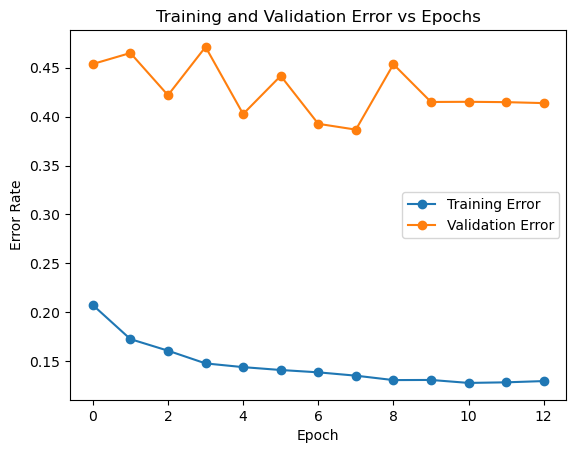

401/401 [==============================] - 301s 749ms/step
              precision    recall  f1-score   support

           0       0.36      0.31      0.33      4418
           1       0.66      0.70      0.68      8405

    accuracy                           0.57     12823
   macro avg       0.51      0.51      0.51     12823
weighted avg       0.55      0.57      0.56     12823



In [12]:
#Plot the training and validation errors vs. epochs
trainErrorRN50 = [1 - score for score in hRN50.history['accuracy']]
validationErrorRN50 = [1 - score for score in hRN50.history['val_accuracy']]

plt.plot(trainErrorRN50, label='Training Error', marker='o')  # Plotting error
plt.plot(validationErrorRN50, label='Validation Error', marker='o')  # Plotting error
plt.title('Training and Validation Error vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

#Report Precision, Recall, and F1 score for your model
bestRN50pred = load_model('bestRN50.h5').predict(tf_dataset_test)
predLabelsRN50 = np.argmax(bestRN50pred, axis=1).flatten()
print(classification_report(trueLabels, predLabelsRN50))

## Transfer Learning using VGG16

In [13]:
#VGG16
VGG16base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
VGG16base.trainable = False

VGG16model = Sequential([
    VGG16base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')])

VGG16model.compile(optimizer ='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hVGG16 = VGG16model.fit(
    tf_dataset_train_augmented,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
                 ModelCheckpoint('bestVGG16.h5', monitor='val_accuracy', save_best_only=True)])


Epoch 1/20
928/928 [==============================] - 1548s 2s/step - loss: 0.3552 - accuracy: 0.8413 - val_loss: 1.1948 - val_accuracy: 0.5634
Epoch 2/20
928/928 [==============================] - 1546s 2s/step - loss: 0.2856 - accuracy: 0.8776 - val_loss: 1.2035 - val_accuracy: 0.6073
Epoch 3/20
928/928 [==============================] - 1546s 2s/step - loss: 0.2654 - accuracy: 0.8879 - val_loss: 1.1662 - val_accuracy: 0.6303
Epoch 4/20
928/928 [==============================] - 1546s 2s/step - loss: 0.2477 - accuracy: 0.8969 - val_loss: 1.6369 - val_accuracy: 0.5720
Epoch 5/20
928/928 [==============================] - 1546s 2s/step - loss: 0.2358 - accuracy: 0.9020 - val_loss: 1.2113 - val_accuracy: 0.6507
Epoch 6/20
928/928 [==============================] - 1546s 2s/step - loss: 0.2291 - accuracy: 0.9025 - val_loss: 1.3403 - val_accuracy: 0.6294
Epoch 7/20
928/928 [==============================] - 1546s 2s/step - loss: 0.2251 - accuracy: 0.9074 - val_loss: 1.6239 - val_accuracy:

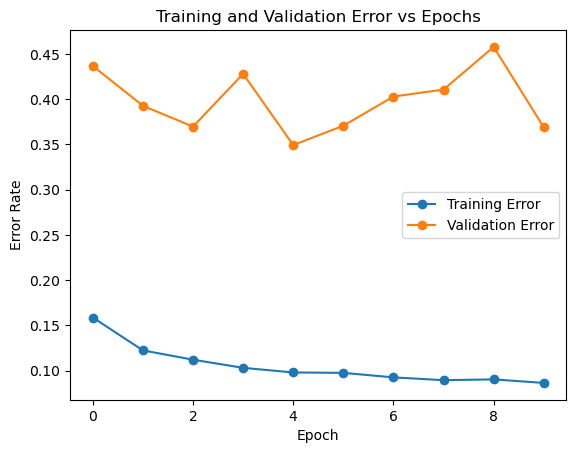

401/401 [==============================] - 483s 1s/step
              precision    recall  f1-score   support

           0       0.35      0.40      0.38      4418
           1       0.66      0.61      0.63      8405

    accuracy                           0.54     12823
   macro avg       0.51      0.51      0.51     12823
weighted avg       0.55      0.54      0.54     12823



In [14]:
#Plot the training and validation errors vs. epochs
trainErrorVGG16 = [1 - score for score in hVGG16.history['accuracy']]
validationErrorVGG16 = [1 - score for score in hVGG16.history['val_accuracy']]

plt.plot(trainErrorVGG16, label='Training Error', marker='o')  # Plotting error
plt.plot(validationErrorVGG16, label='Validation Error', marker='o')  # Plotting error
plt.title('Training and Validation Error vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

#Report Precision, Recall, and F1 score for your model
bestVGG16pred = load_model('bestVGG16.h5').predict(tf_dataset_test)
predLabelsVGG16 = np.argmax(bestVGG16pred, axis=1).flatten()
print(classification_report(trueLabels, predLabelsVGG16))

## Comparing the results of transfer learning with those of CNN + MLP model and explain them

The CNN model has fluctuating validation error, with early stopping at epoch 6.

The EfficientNet model sees high training and validation error. This is because this model has very high recall on class 1 (1.0). Although, this model has the highest accuracy of the four models.

The ResNet models sees lower training error, with a relatively consistent validation error (slight fluctuations). This model has a higher accuracy than the initial CNN model.

The VGG model appears to have the lowest training error, with a slightly fluctuating validation error. 

In terms of validation error, the CNN model has the lowest of the four at it's first epoch.

In terms of balance, the CNN model seems to be the best for this data. 
The EfficientNet model simply classifies all images to one class, making it not a good learner.
The ResNet and VGG model perform very similarly, with the VGG model requiring more computational efforts.

Future work would benefit from letting all models run 20 epochs, this would lead to more precise results from the models, however, for this project, time does not allow.